In [13]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, autoguide
import jax.numpy as jnp
from jax import vmap
import jax.random as jra
import numpy as np
import matplotlib.pyplot as plt


class StudentTProcess:
    def __init__(
        self, lengthscale_prior, amplitude_prior, nu_prior, noise_prior, num_steps=2000
    ):
        self.num_steps = num_steps

        self.lengthscale_prior = lengthscale_prior or dist.TruncatedNormal(
            0.5, 0.5, low=0.1
        )
        self.amplitude_prior = amplitude_prior or dist.LogNormal(2.0, 2.0)
        self.nu_prior = nu_prior or dist.LogNormal(-2.0, 0.5)
        self.noise_prior = noise_prior or dist.LogNormal(-2.0, 0.5)

    def squared_exponential_kernel(self, xi, xj, amplitude, length_scale, jitter=1e-10):
        """Compute SE kernel between all pairs of inputs."""
        xi = xi.reshape(-1, 1) if len(xi.shape) == 1 else xi
        xj = xj.reshape(-1, 1) if len(xj.shape) == 1 else xj

        diff = xi[:, None, :] - xj[None, :, :]
        scaled_diff = diff / length_scale
        r = jnp.sum(scaled_diff**2, axis=-1)
        K = amplitude**2 * jnp.exp(-0.5 * r)

        # Add jitter to diagonal for numerical stability
        K = K + jitter * jnp.eye(xi.shape[0]) if xi.shape == xj.shape else K
        return K

    def model(self, X, y=None):
        """Student-t Process regression model."""
        # Get dimensions
        N = X.shape[0]

        # Sample model parameters
        nu = numpyro.sample("nu", self.nu_prior)
        length_scale = numpyro.sample("length_scale", self.lengthscale_prior)
        amplitude = numpyro.sample("amplitude", self.amplitude_prior)
        sigma = numpyro.sample("sigma", self.noise_prior)

        # Compute kernel matrix
        K = self.squared_exponential_kernel(X, X, amplitude, length_scale)
        K = K + sigma**2 * jnp.eye(N)

        # Sample y according to Student-t Process
        numpyro.sample(
            "y",
            dist.MultivariateStudentT(
                df=nu, loc=jnp.zeros(N), scale_tril=jnp.linalg.cholesky(K)
            ),
            obs=y,
        )

    def fit(self, X, y, rng_key):
        """Fit the Student-t Process using VI."""
        # Initialize guide
        self.guide = autoguide.AutoMultivariateNormal(self.model)

        # Setup SVI
        svi = SVI(
            self.model,
            self.guide,
            numpyro.optim.Adam(step_size=0.01),
            loss=Trace_ELBO(num_particles=4),
        )

        # Run SVI
        self.svi_result = svi.run(rng_key, self.num_steps, X=X, y=y)

        return self.svi_result

    def predict(self, X_new, X_train, y_train, rng_key, num_samples=512):
        """Make predictions at new input locations."""
        # Get the optimized parameters from SVI
        params = self.svi_result.params

        # Get posterior samples from the guide
        posterior_samples = self.guide.sample_posterior(
            rng_key, params, sample_shape=(num_samples,)
        )

        # Compute predictive distribution parameters for each posterior sample
        def predict_single(params):
            nu = params["nu"]
            length_scale = params["length_scale"]
            amplitude = params["amplitude"]
            sigma = params["sigma"]

            # Compute kernel matrices
            K = self.squared_exponential_kernel(
                X_train, X_train, amplitude, length_scale
            )
            K = K + sigma**2 * jnp.eye(X_train.shape[0])

            K_star = self.squared_exponential_kernel(
                X_new, X_train, amplitude, length_scale
            )
            K_star_star = self.squared_exponential_kernel(
                X_new, X_new, amplitude, length_scale
            )

            # Compute predictive mean and covariance
            L = jnp.linalg.cholesky(K)
            alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, y_train))
            mean = K_star @ alpha

            # Compute beta1 (quadratic form y'K^(-1)y)
            beta1 = y_train.T @ alpha

            v = jnp.linalg.solve(L, K_star.T)
            covar = K_star_star - v.T @ v

            # Scale covariance according to Student-t predictive with beta1
            scale = (nu + beta1 - 2) / (nu + y_train.shape[0] - 2)
            covar = scale * covar

            return mean, covar

        # Compute predictions for all samples
        means, covars = vmap(predict_single)(posterior_samples)

        return means, covars


class VariationalGP:
    def __init__(
        self, lengthscale_prior, amplitude_prior, noise_prior, num_steps=2000
    ):
        self.num_steps = num_steps
        self.lengthscale_prior = lengthscale_prior or dist.TruncatedNormal(
            0.5, 0.5, low=0.1
        )
        self.amplitude_prior = amplitude_prior or dist.LogNormal(2.0, 2.0)
        self.noise_prior = noise_prior or dist.LogNormal(-2.0, 0.5)

    def squared_exponential_kernel(self, xi, xj, amplitude, length_scale, jitter=1e-10):
        xi = xi.reshape(-1, 1) if len(xi.shape) == 1 else xi
        xj = xj.reshape(-1, 1) if len(xj.shape) == 1 else xj

        diff = xi[:, None, :] - xj[None, :, :]
        scaled_diff = diff / length_scale
        r = jnp.sum(scaled_diff**2, axis=-1)
        K = amplitude**2 * jnp.exp(-0.5 * r)

        K = K + jitter * jnp.eye(xi.shape[0]) if xi.shape == xj.shape else K
        return K

    def model(self, X, y=None):
        N = X.shape[0]

        length_scale = numpyro.sample("length_scale", self.lengthscale_prior)
        amplitude = numpyro.sample("amplitude", self.amplitude_prior)
        sigma = numpyro.sample("sigma", self.noise_prior)

        K = self.squared_exponential_kernel(X, X, amplitude, length_scale)
        K = K + sigma**2 * jnp.eye(N)

        numpyro.sample(
            "y", dist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=K), obs=y
        )

    def fit(self, X, y, rng_key):
        self.guide = autoguide.AutoMultivariateNormal(self.model)

        svi = SVI(
            self.model,
            self.guide,
            numpyro.optim.Adam(step_size=0.01),
            loss=Trace_ELBO(num_particles=4),
        )

        self.svi_result = svi.run(rng_key, self.num_steps, X=X, y=y)

        return self.svi_result

    def predict(self, X_new, X_train, y_train, rng_key, num_samples=512):
        params = self.svi_result.params
        posterior_samples = self.guide.sample_posterior(
            rng_key, params, sample_shape=(num_samples,)
        )

        def predict_single(params):
            length_scale = params["length_scale"]
            amplitude = params["amplitude"]
            sigma = params["sigma"]

            K = self.squared_exponential_kernel(
                X_train, X_train, amplitude, length_scale
            )
            K = K + sigma**2 * jnp.eye(X_train.shape[0])

            K_star = self.squared_exponential_kernel(
                X_new, X_train, amplitude, length_scale
            )
            K_star_star = self.squared_exponential_kernel(
                X_new, X_new, amplitude, length_scale
            )

            L = jnp.linalg.cholesky(K)
            alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, y_train))
            mean = K_star @ alpha

            v = jnp.linalg.solve(L, K_star.T)
            covar = K_star_star - v.T @ v

            return mean, covar

        means, covars = vmap(predict_single)(posterior_samples)
        return means, covars


# Generate synthetic data
def generate_synthetic_data(
    key, n_points=50, noise_std=0.25, outlier_magnitude=1.0, num_outliers=5
):
    X = jnp.linspace(0.0, jnp.pi * 2, n_points)[:, None]
    # noise = jra.normal(key, X.shape) * noise_std
    noise = jra.t(key, df=2, shape=X.shape) * noise_std
    Y = jnp.sin(X)
    Y = Y / jnp.abs(Y).max()
    Yc = (
        Y.at[int(n_points * 0.75) : int(n_points * 0.75) + num_outliers].add(
            outlier_magnitude
        )
        + noise
    )
    X = X / X.max()
    return X, Y.reshape(-1), Yc.reshape(-1)

100%|██████████| 4000/4000 [00:02<00:00, 1947.67it/s, init loss: 92.3354, avg. loss [3801-4000]: 35.7595]



Student-t Process Posterior Parameter Summary:
   amplitude: mean = 0.910, std = 0.451
length_scale: mean = 0.190, std = 0.043
          nu: mean = 2.674, std = 0.386
       sigma: mean = 0.423, std = 0.160

Gaussian Process Posterior Parameter Summary:
   amplitude: mean = 0.773, std = 0.293
length_scale: mean = 0.194, std = 0.046
       sigma: mean = 0.381, std = 0.045

Student-t Process Metrics:
MAE: 0.1603
RMSE: 0.2128
NLL: 0.3141

Variational GP Metrics:
MAE: 0.1564
RMSE: 0.2092
NLL: 0.2289


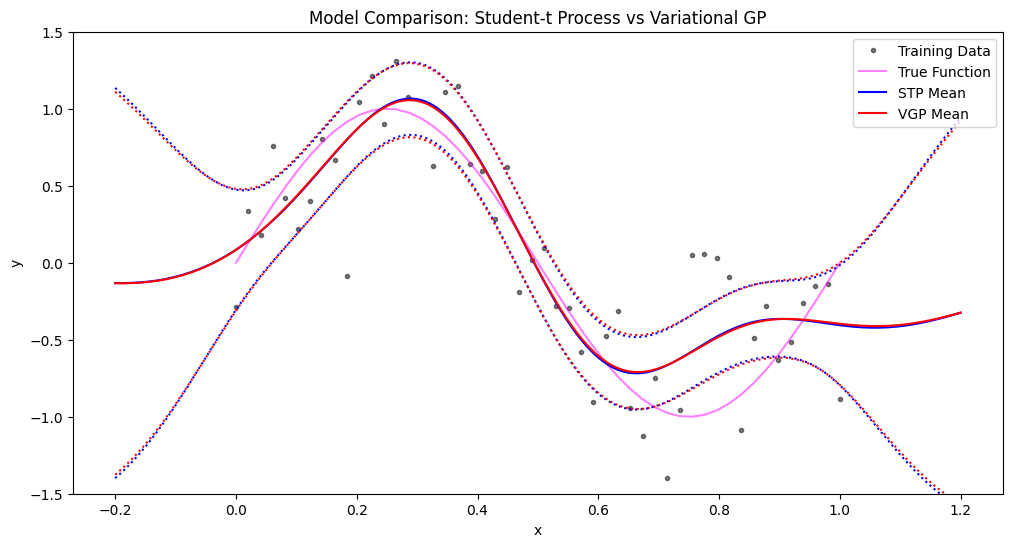

In [17]:
# Set seeds
rng_key = jra.PRNGKey(0)
keys = jra.split(rng_key, 6)

# Generate data
X_train, y_true, y_train = generate_synthetic_data(key=keys[0], n_points=50, num_outliers=4, noise_std=0.2, outlier_magnitude=1.0)

# Fit both models
num_steps = 4000

nu_prior = dist.TruncatedNormal(loc=2.5, scale=0.5, low=2.0)
lengthscale_prior = dist.TruncatedNormal(0.5, 0.5, low=0.1)
# lengthscale_prior = dist.LogNormal(0.0, 1.0)
amplitude_prior = dist.LogNormal(0.0, 1.0)
noise_prior = dist.LogNormal(0.0, 1.0)

stp_model = StudentTProcess(num_steps=num_steps, nu_prior=nu_prior, lengthscale_prior=lengthscale_prior, amplitude_prior=amplitude_prior, noise_prior=noise_prior)
vgp_model = VariationalGP(num_steps=num_steps, lengthscale_prior=lengthscale_prior, amplitude_prior=amplitude_prior, noise_prior=noise_prior)

stp_result = stp_model.fit(X_train, y_train, keys[1])
vgp_result = vgp_model.fit(X_train, y_train, keys[2])

def print_posterior_summary(model, name):
    params = model.svi_result.params
    posterior_samples = model.guide.sample_posterior(
        jra.PRNGKey(0),
        params,
        sample_shape=(1000,)
    )
    
    print(f"\n{name} Posterior Parameter Summary:")
    for param, values in posterior_samples.items():
        mean = jnp.mean(values)
        std = jnp.std(values)
        print(f"{param:>12}: mean = {mean:.3f}, std = {std:.3f}")

# After fitting both models
print_posterior_summary(stp_model, "Student-t Process")
print_posterior_summary(vgp_model, "Gaussian Process")
print("")

# Generate test points matching training data points
X_test = X_train
# X_test = jnp.linspace(-0.1, 1.1, 100)[:, None]

stp_means, stp_covars = stp_model.predict(X_test, X_train, y_train, keys[3])
vgp_means, vgp_covars = vgp_model.predict(X_test, X_train, y_train, keys[4])

# Compute predictive statistics
stp_mean = jnp.mean(stp_means, axis=0)
stp_std = jnp.sqrt(jnp.mean(stp_covars.diagonal(axis1=1, axis2=2), axis=0))

vgp_mean = jnp.mean(vgp_means, axis=0)
vgp_std = jnp.sqrt(jnp.mean(vgp_covars.diagonal(axis1=1, axis2=2), axis=0))

# Compute metrics
def compute_metrics(mean, std, y_true):
    mae = jnp.mean(jnp.abs(mean - y_true))
    rmse = jnp.sqrt(jnp.mean((mean - y_true)**2))
    nll = -jnp.mean(jnp.log(jnp.exp(-0.5 * ((y_true - mean) / std)**2) / 
                           (std * jnp.sqrt(2 * jnp.pi))))
    return mae, rmse, nll

stp_mae, stp_rmse, stp_nll = compute_metrics(stp_mean, stp_std, y_true)
vgp_mae, vgp_rmse, vgp_nll = compute_metrics(vgp_mean, vgp_std, y_true)

print(f"Student-t Process Metrics:")
print(f"MAE: {stp_mae:.4f}")
print(f"RMSE: {stp_rmse:.4f}")
print(f"NLL: {stp_nll:.4f}\n")

print(f"Variational GP Metrics:")
print(f"MAE: {vgp_mae:.4f}")
print(f"RMSE: {vgp_rmse:.4f}")
print(f"NLL: {vgp_nll:.4f}")

# Generate dense test points for smooth plotting
X_plot = jnp.linspace(-0.2, 1.2, 200)[:, None]
stp_means_plot, stp_covars_plot = stp_model.predict(X_plot, X_train, y_train, keys[3])
vgp_means_plot, vgp_covars_plot = vgp_model.predict(X_plot, X_train, y_train, keys[4])

stp_mean_plot = jnp.mean(stp_means_plot, axis=0)
stp_std_plot = jnp.sqrt(jnp.mean(stp_covars_plot.diagonal(axis1=1, axis2=2), axis=0))

vgp_mean_plot = jnp.mean(vgp_means_plot, axis=0)
vgp_std_plot = jnp.sqrt(jnp.mean(vgp_covars_plot.diagonal(axis1=1, axis2=2), axis=0))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_train, y_train, 'k.', label='Training Data', alpha=0.5)
plt.plot(X_train, y_true, 'magenta', label='True Function', alpha=0.5)

plt.plot(X_plot, stp_mean_plot, 'b-', label='STP Mean')
plt.plot(X_plot, stp_mean_plot - 2*stp_std_plot, ls=':', color='b')
plt.plot(X_plot, stp_mean_plot + 2*stp_std_plot, ls=':', color='b')

plt.plot(X_plot, vgp_mean_plot, 'r-', label='VGP Mean')
plt.plot(X_plot, vgp_mean_plot - 2*vgp_std_plot, ls=':', color='r')
plt.plot(X_plot, vgp_mean_plot + 2*vgp_std_plot, ls=':', color='r')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Comparison: Student-t Process vs Variational GP')
plt.legend()
plt.ylim(-1.5, 1.5)
plt.show()

100%|██████████| 5000/5000 [00:03<00:00, 1357.13it/s, init loss: 111.7388, avg. loss [4751-5000]: 67.4580]



Student-t Process Metrics:
MAE: 0.4127
RMSE: 0.5652
NLL: 7.2874

Variational GP Metrics:
MAE: 0.4108
RMSE: 0.5653
NLL: 6.9925


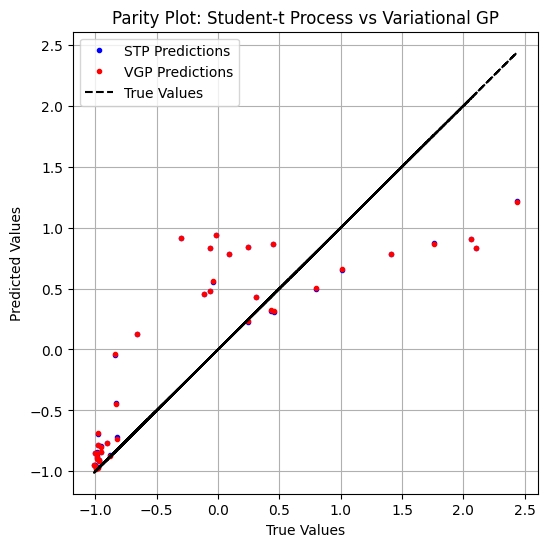

In [12]:
import pandas as pd

# df = pd.read_csv("data/AutoAM_dataset.csv")
df = pd.read_csv("data/P3HT_dataset.csv")

# drop duplicates in all by the last column and take mean of the last column
df = df.groupby(list(df.columns[:-1])).mean().reset_index()

try:
    df = df.sample(n=100, random_state=42)
except:
    print("too little data")

X = jnp.array(df.iloc[:, :-1].values)
y = jnp.array(df.iloc[:, -1].values)

# normalize the X values to be between 0 and 1
# standardize the y values

X = (X - X.min()) / (X.max() - X.min())
y = (y - y.mean()) / y.std()

train_idx = jra.choice(jra.PRNGKey(0), X.shape[0], shape=(int(X.shape[0]*0.6),), replace=False)

Xdata_train, ydata_train = X[train_idx], y[train_idx]
Xdata_test, ydata_test = X[~jnp.isin(jnp.arange(X.shape[0]), train_idx)], y[~jnp.isin(jnp.arange(X.shape[0]), train_idx)]

# Fit both models
num_steps = 5000

stp_model = StudentTProcess(num_steps=num_steps, nu_prior=nu_prior, lengthscale_prior=lengthscale_prior, amplitude_prior=amplitude_prior, noise_prior=noise_prior)
vgp_model = VariationalGP(num_steps=num_steps, lengthscale_prior=lengthscale_prior, amplitude_prior=amplitude_prior, noise_prior=noise_prior)


stp_result = stp_model.fit(Xdata_train, ydata_train, keys[1])
vgp_result = vgp_model.fit(Xdata_train, ydata_train, keys[2])

stp_means, stp_covars = stp_model.predict(Xdata_test, Xdata_train, ydata_train, keys[3])
vgp_means, vgp_covars = vgp_model.predict(Xdata_test, Xdata_train, ydata_train, keys[4])

# Compute predictive statistics
stp_mean = jnp.mean(stp_means, axis=0)
stp_std = jnp.sqrt(jnp.mean(stp_covars.diagonal(axis1=1, axis2=2), axis=0))

vgp_mean = jnp.mean(vgp_means, axis=0)
vgp_std = jnp.sqrt(jnp.mean(vgp_covars.diagonal(axis1=1, axis2=2), axis=0))

stp_mae, stp_rmse, stp_nll = compute_metrics(stp_mean, stp_std, ydata_test)
vgp_mae, vgp_rmse, vgp_nll = compute_metrics(vgp_mean, vgp_std, ydata_test)


print(f"\nStudent-t Process Metrics:")
print(f"MAE: {stp_mae:.4f}")
print(f"RMSE: {stp_rmse:.4f}")
print(f"NLL: {stp_nll:.4f}\n")

print(f"Variational GP Metrics:")
print(f"MAE: {vgp_mae:.4f}")
print(f"RMSE: {vgp_rmse:.4f}")
print(f"NLL: {vgp_nll:.4f}")

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(ydata_test, stp_mean, 'b.', label='STP Predictions')
plt.plot(ydata_test, vgp_mean, 'r.', label='VGP Predictions')
plt.plot(ydata_test, ydata_test, 'k--', label='True Values')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: Student-t Process vs Variational GP')
plt.legend()
plt.grid(True)
plt.show()
